This notebook is for the plots reproduced from the lecture notes and associated papers. Will fill up with time.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob as g
import pandas as pd
from scipy.interpolate import griddata

In [2]:
file = sorted(g.glob('output_rrtm_MLS-clr*'))
print(file)

finput = sorted(g.glob('input_rrtm_MLS-clr*'))
print(finput)

['output_rrtm_MLS-clr', 'output_rrtm_MLS-clr-CO2', 'output_rrtm_MLS-clr-H2O', 'output_rrtm_MLS-clr-O3']
['input_rrtm_MLS-clr', 'input_rrtm_MLS-clr-CO2', 'input_rrtm_MLS-clr-H2O', 'input_rrtm_MLS-clr-O3']


In [3]:
def rrtmg_lw_input_read(nlev, file):
    temparr = np.empty(0);
    parr = np.empty(0);
    tave = np.empty(0);
    pave = np.empty(0);
    mix_ratio = np.array([[0.0 for x in range(8)]for y in range(51)]);
    
    fi = open(finput[0], 'r')
    lines = fi.readlines()[0:]

    line7 = lines[7].split()
    #Updating pressure and temperature for top and bottom of 1st layer separately
    temparr = np.append(temparr, line7[5])
    parr = np.append(parr, line7[4])
    temparr = np.append(temparr, line7[8])
    parr = np.append(parr, line7[7])
    tave = np.append(tave, line7[1]);
    pave = np.append(pave, line7[0]);    

    for j in range(9,nlev,2):
       tmp1 = lines[j];
       tmpave = tmp1.split();
       tave = np.append(tave, tmpave[1]);
       pave = np.append(pave, tmpave[0]);
       indices = [71];
       tmp2 = [tmp1[i:j] for i,j in zip(indices, indices[1:]+[None])];
       tmp3 = np.empty([0,0])
       for val in tmp2:
        tmp3 = np.append(tmp3, val.split())
       temparr = np.append(temparr, tmp3[1])
       parr = np.append(parr, tmp3[0])

    for j in range(8, nlev, 2):
       tmp1 = lines[j]
       tmp2 = tmp1.split()
       for u in range(0,len(tmp2)):
           tmp2[u] = float(tmp2[u])
       # print(tmp2)
       for k in range(0,len(tmp2)):
         mix_ratio[(j-8)//2][k] = tmp2[k]
        
    temparr = [float(val) for val in temparr]
    parr = [float(value) for value in parr]
    tave = [float(val) for val in tave]
    pave = [float(value) for value in pave]    
    fi.close()

    return temparr, parr, tave, pave, mix_ratio

In [4]:
def rrtmg_lw_output_read(nlev, file, string):
    lvl = np.full(nlev,np.nan);
    prs = np.full(nlev,np.nan);
    fup = np.full(nlev,np.nan);
    fdn = np.full(nlev,np.nan);
    fnt = np.full(nlev,np.nan);
    htr = np.full(nlev,np.nan);
    
    fi  = open(file,'r')
    lines = fi.readlines()[0:]
    for row in lines:
        # check if string present on a current line
        word = string
        # if found it returns index of the first occurrence of the substring
        if row.find(word) != -1:
            #print('string exists in file')
            index = lines.index(row)
            #print(index)
            lines = lines[index+3:]
            break
    
    #print(lines)
    

    for j in range(0,nlev):

        tmp1 = lines[j];
        tmp2 = tmp1.split();
        lvl[j] = tmp2[0];
        prs[j] = tmp2[1];
        fup[j] = tmp2[2];
        fdn[j] = tmp2[3];
        fnt[j] = tmp2[4];
        htr[j] = tmp2[5]; 
        
    lvl = lvl[::-1]
    prs = prs[::-1]
    fup = fup[::-1]
    fdn = fdn[::-1]
    fnt = fnt[::-1]
    htr = htr[::-1]
    
    fi.close()
    return lvl,prs,fnt,htr,string,fup,fdn

Define an array for all strings:

bands = np.array(['10.0 -  350.0', '350.0 -  500.0', '500.0 -  630.0', '630.0 -  700.0', '700.0 -  820.0','820.0 -  980.0', '980.0 - 1080.0', '1080.0 - 1180.0', '1180.0 - 1390.0', '1390.0 - 1480.0', '1480.0 - 1800.0',  '1800.0 - 2080.0', '2080.0 - 2250.0', '2250.0 - 2380.0', '2380.0 - 2600.0', '2600.0 - 3250.0'])

In [5]:
def return_bands():
    bands = np.array(['10.0 -  350.0', '350.0 -  500.0', '500.0 -  630.0', '630.0 -  700.0', '700.0 -  820.0','820.0 -  980.0', '980.0 - 1080.0', '1080.0 - 1180.0', '1180.0 - 1390.0', '1390.0 - 1480.0', '1480.0 - 1800.0',  '1800.0 - 2080.0', '2080.0 - 2250.0', '2250.0 - 2380.0', '2380.0 - 2600.0', '2600.0 - 3250.0', '10.0 - 3250.0'])
    return bands

In [6]:
input_mls = rrtmg_lw_input_read(109, finput[0])

In [7]:
output_51l = rrtmg_lw_output_read(51,file[0],return_bands()[16]) #Midlattitude summer sky, clear conditions, 51 layers

In [8]:
bandfull = return_bands()[:-1]
bandfull = [p.split() for p in bandfull]
bands = [(float(p[2])+float(p[0]))/2 for p in bandfull] #Interpolating across average values
widths = [(float(p[2])-float(p[0])) for p in bandfull] #bandwidth
# bands = [float(p[0]) for p in bandfull]
print(bandfull)
print(bands)
print(widths)

[['10.0', '-', '350.0'], ['350.0', '-', '500.0'], ['500.0', '-', '630.0'], ['630.0', '-', '700.0'], ['700.0', '-', '820.0'], ['820.0', '-', '980.0'], ['980.0', '-', '1080.0'], ['1080.0', '-', '1180.0'], ['1180.0', '-', '1390.0'], ['1390.0', '-', '1480.0'], ['1480.0', '-', '1800.0'], ['1800.0', '-', '2080.0'], ['2080.0', '-', '2250.0'], ['2250.0', '-', '2380.0'], ['2380.0', '-', '2600.0'], ['2600.0', '-', '3250.0']]
[180.0, 425.0, 565.0, 665.0, 760.0, 900.0, 1030.0, 1130.0, 1285.0, 1435.0, 1640.0, 1940.0, 2165.0, 2315.0, 2490.0, 2925.0]
[340.0, 150.0, 130.0, 70.0, 120.0, 160.0, 100.0, 100.0, 210.0, 90.0, 320.0, 280.0, 170.0, 130.0, 220.0, 650.0]


In [9]:
htr = np.empty(0)
prs = np.empty(0)
for i in range(16):
    output = rrtmg_lw_output_read(51,file[0],return_bands()[i])
    htr = np.concatenate((htr, output[3][:-2]/widths[i])) #Averaging over bandwidths
    prs = np.concatenate((prs, output[1][:-2]))
bandarr = [np.repeat(bands[i], 49) for i in range(16)]
bandarr = np.concatenate(bandarr).ravel()
# htr = [-p+min(htr) for p in htr]
htr = [-p for p in htr]
print(len(htr))
print(len(prs))
print(len(bandarr))

784
784
784


In [10]:
df = pd.DataFrame({'x':bandarr, 'y':prs, 'z':htr})
print(min(df.z))
print(max(df.z))

-0.0026669
0.09386871428571428


Text(0.5, 1.0, 'Cooling rate dependence on Pressure and Wavenumber')

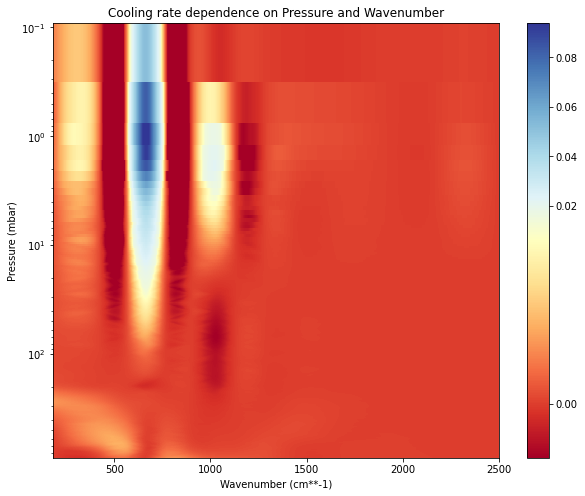

In [18]:
import matplotlib
nx = 2000
ny = 2000
vmin = min(df.z)
vmax = max(df.z)
xi = np.linspace(min(df.x), max(df.x), nx)
yi = np.linspace(min(df.y), max(df.y), ny)
x, y = np.meshgrid(xi,yi)
z = griddata((df.x,df.y), df.z, (x,y), method='cubic')

def forward(x):
    y = (x + 0.065)
    y = np.where(x < -0.001, 10 * (x + 0.001), y)
    y = np.where((x < 0.015) & (x >= -0.001), 5 * (x + 0.001), y)
    return y
    
def inverse(x):
    y = (x - 0.065)
    y = np.where(x < 0.0, x / 10 - 0.001, y)
    y = np.where((x >= 0.0) & (x < 0.08), x / 5 - 0.001, y)
    return y

norm = matplotlib.colors.FuncNorm((forward, inverse), vmin=vmin, vmax=vmax)

fig,ax = plt.subplots(figsize=(10,8))
plt.pcolormesh(x,y,z, norm=norm, cmap='RdYlBu')
#plt.contour(x,y,z, levels=2)
# plt.contourf(x,y,z, norm=matplotlib.colors.Normalize(vmin=vmin,vmax=vmax), cmap='viridis_r')
plt.xlabel('Wavenumber (cm**-1)')
plt.xlim(180,2500)
plt.ylabel('Pressure (mbar)')
plt.yscale('log')
plt.ylim(max(df.y),min(df.y))
plt.colorbar()
plt.title('Cooling rate dependence on Pressure and Wavenumber')

I believe the features owing to CO2, O3 and H2O are quite visible. I divided the heating rate (interpolated) by the bandwidth, so the averaging is not uniform - but the left side features seem decently reproduced despite the large bandwidths. The right hand side features aren't well captured at all, which is mostly due to the colormap being linear - but even with power law or log I couldn't get a good representation. Probably need to define a weird piecewise custom colormap.

Text(0.5, 1.0, 'Heating Rate (minimum shifted to zero) dependence on Pressure and Wavenumber')

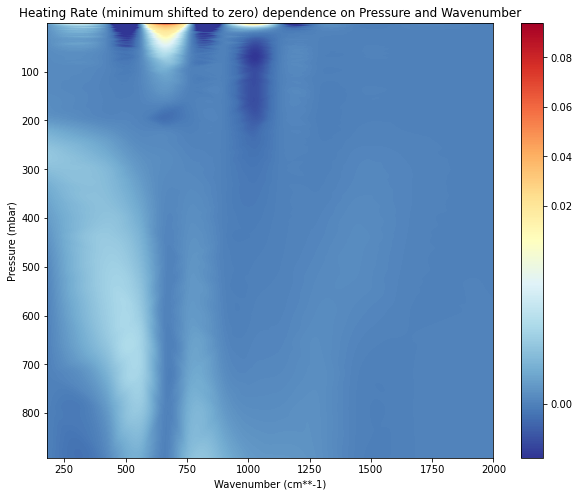

In [20]:
fig,ax = plt.subplots(figsize=(10,8))
plt.pcolormesh(x,y,z, norm=norm, cmap='RdYlBu_r')
# plt.contourf(x,y,z, norm=matplotlib.colors.Normalize(vmin=vmin,vmax=vmax), cmap='Reds')
plt.xlabel('Wavenumber (cm**-1)')
plt.xlim(180,2000)
plt.ylabel('Pressure (mbar)')
plt.ylim(max(df.y),min(df.y))
plt.colorbar()
plt.title('Heating Rate (minimum shifted to zero) dependence on Pressure and Wavenumber')

In [14]:
output_noco2 = rrtmg_lw_output_read(51,file[1],return_bands()[16]) #no CO2
output_noh2o = rrtmg_lw_output_read(51,file[2],return_bands()[16]) #no H2O
output_noo3 = rrtmg_lw_output_read(51,file[3],return_bands()[16]) #no O3

The following plot is not what I expected it to be. The water line looks decent, but the other two - not so much. I have no idea why this happens - I zeroed the gas mixing ratios (each) and subtracted the subsequent heating rate from the net heating rate (when all gases are present).

Text(0.5, 1.0, 'MLS heating rate for clear skies, full bandwidth')

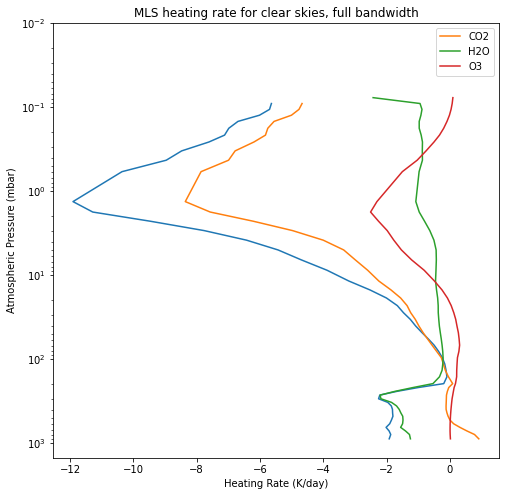

In [27]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(output_51l[3][:-2], output_51l[1][:-2])
ax.plot(output_51l[3][:-2]-output_noco2[3][:-2], output_51l[1][:-2], label='CO2')
ax.plot(output_51l[3][:-1]-output_noh2o[3][:-1], output_51l[1][:-1], label='H2O')
ax.plot(output_51l[3][:-1]-output_noo3[3][:-1], output_51l[1][:-1], label='O3')
ax.set_xlabel('Heating Rate (K/day)')
ax.set_ylabel('Atmospheric Pressure (mbar)')
ax.set_yscale('log')
ax.set_ylim(1500,0.01)
ax.legend()
ax.set_title('MLS heating rate for clear skies, full bandwidth')